In [173]:
#reload source files automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [179]:
import pandas as pd

import event_clustering.preprocessing
from event_clustering.clustering import find_optimal_clusters, plot_tsne_pca, get_top_keywords

In [180]:
filepath = 'data/DomesticDeclarations.xes'

In [181]:
df = load(filepath)

In [182]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(df['concept:name'])
text = tfidf.transform(df['concept:name'])

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


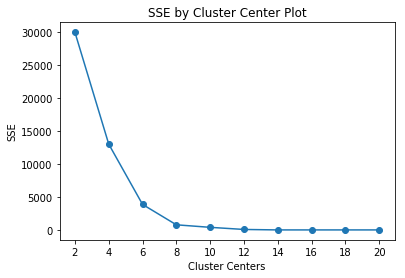

In [183]:
find_optimal_clusters(text, 20)

In [184]:
clusters = MiniBatchKMeans(n_clusters=14, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

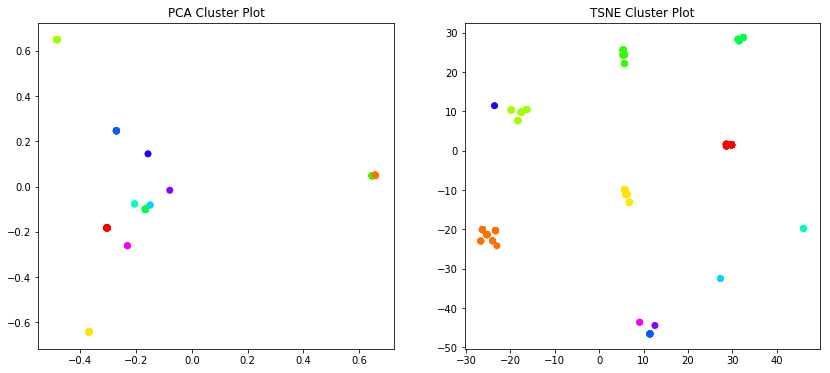

In [185]:
plot_tsne_pca(text, clusters)

In [186]:
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
payment,pre_approver,rejected,request,saved,submitted,supervisor,declaration,approved,administration

Cluster 1
handled,missing,owner,pre_approver,rejected,saved,submitted,supervisor,payment,request

Cluster 2
owner,payment,pre_approver,rejected,request,saved,submitted,declaration,supervisor,final_approved

Cluster 3
owner,payment,pre_approver,rejected,request,saved,supervisor,declaration,employee,submitted

Cluster 4
missing,owner,pre_approver,rejected,request,saved,submitted,supervisor,payment,handled

Cluster 5
pre_approver,rejected,request,saved,submitted,supervisor,declaration,approved,budget,owner

Cluster 6
owner,payment,pre_approver,request,saved,submitted,supervisor,declaration,administration,rejected

Cluster 7
owner,payment,rejected,request,saved,submitted,supervisor,declaration,approved,pre_approver

Cluster 8
owner,payment,pre_approver,request,saved,submitted,supervisor,declaration,employee,rejected

Cluster 9
owner,payment,pre_approver,rejected,request,submitte